# Result Analysis
This notebook converts the extracted csv files produced by the experiments into dataframes and calculates central metrics on them as well as visualizing them. Our experiment tries out different Llama models on the Evoprompt tasks with two different al

In [381]:
from typing import List
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

In [382]:
plt.style.use('mpl_stylesheet.mplstyle')

In [383]:
def read_prompts(target_experiment: str, tasks: List[str]):
    results = pd.DataFrame()
    for logging_dir in Path(f"../logs/{target_experiment}").rglob("*.csv"):
        if "best_scores" in str(logging_dir) or not any(task in str(logging_dir) for task in tasks):
            continue

        result = pd.read_csv(logging_dir)

        logging_dir = str(logging_dir)

        logging_dir = logging_dir.replace(f"..\\logs\\{target_experiment}\\", "")
        logging_dir = logging_dir.replace(".csv", "")

        task_name, optimizer, meta_llm, evaluation_llm, random_seed = logging_dir.split("_")

        metainformation = pd.DataFrame(
            {
                "task": [task_name]*len(result),
                "optimizer": [optimizer]*len(result),
                "meta_llm": [meta_llm]*len(result),
                "evaluation_llm": [evaluation_llm]*len(result),
                "random_seed": [random_seed]*len(result),
            }
        )

        result = pd.concat([result, metainformation], axis=1)

        results = pd.concat([result, results], axis=0)

    return results

def read_best_scores(target_experiment: str):
    return pd.read_csv(f"../logs/{target_experiment}/best_scores.csv")

def get_mean_std(df):
    group_cols = ["task", "optimizer", "meta_llm", "downstream_llm", "use_task_desc"]
    df_copy = df.groupby(group_cols).agg("mean", numeric_only=True).drop(columns="random_seed")
    df_copy["test_score_std"] = df.groupby(group_cols).agg("std", numeric_only=True).drop(columns="random_seed")["test_score"]
    df_copy = df_copy.reset_index()

    return df_copy

def get_avg_across_tasks(df):
    df_avg = df.groupby(['optimizer', 'meta_llm', "downstream_llm", "use_task_desc"]).agg({
        'test_score': 'mean',
    }).reset_index()

    df_avg["task"] = "Average"

    df = pd.concat([df, df_avg], axis="index")

    return df

def clean_names(df):
    def map_task_desc(row):
        if row is None:
            return False
        if type(row) is not str:
            return False
        return  ".txt" in row
        
    llm_cols = ["meta_llm", "downstream_llm"]
    df[llm_cols] =\
        df[llm_cols]\
            .replace({c: {
                "meta-llama/Meta-Llama-3-70B-Instruct": "Llama-3-70B",
                "meta-llama\Meta-Llama-3-70B-Instruct": "Llama-3-70B",
                "meta-llama/Meta-Llama-3-8B-Instruct": "Llama-3-8B",
                "meta-llama\Meta-Llama-3-8B-Instruct": "Llama-3-8B",
                "gpt-4o-2024-05-13": "gpt-4o"
            } for c in llm_cols})

    df["optimizer"] = df["optimizer"].map({
        "evopromptde": "DE",
        "evopromptga": "GA",
        "init": "init"
    })

    df["use_task_desc"] = df["use_task_desc"].map(map_task_desc)

    return df

def format_score(df):
    df = df.copy()
    def format_score_(row):
        if pd.isna(row['test_score_std']):
            return f"{row['test_score']:.2f}"
        else:
            return f"{row['test_score']:.2f} ± {row['test_score_std']:.2f}"

    # Apply the formatting
    df['test_score'] = df.apply(lambda row: format_score_({
        'test_score': row['test_score'] * 100,
        'test_score_std': row['test_score_std'] * 100
    }), axis=1)

    # Drop the test_score_std column as it's no longer needed
    df = df.drop('test_score_std', axis=1)

    return df


def get_result_table(df):
    df = df.copy()
    return df.groupby(["meta_llm", "downstream_llm", "optimizer", "task", "use_task_desc"], as_index=False)\
        .first()\
        .pivot(index=['meta_llm', "downstream_llm", 'optimizer', "use_task_desc"], columns='task', values='test_score')

<>:67: SyntaxWarning: invalid escape sequence '\M'
<>:69: SyntaxWarning: invalid escape sequence '\M'
<>:67: SyntaxWarning: invalid escape sequence '\M'
<>:69: SyntaxWarning: invalid escape sequence '\M'
C:\Users\tzehl\AppData\Local\Temp\ipykernel_7740\22673084.py:67: SyntaxWarning: invalid escape sequence '\M'
  "meta-llama\Meta-Llama-3-70B-Instruct": "Llama-3-70B",
C:\Users\tzehl\AppData\Local\Temp\ipykernel_7740\22673084.py:69: SyntaxWarning: invalid escape sequence '\M'
  "meta-llama\Meta-Llama-3-8B-Instruct": "Llama-3-8B",


In [458]:
def plot_bar(df_plot, hue=None):
    df_plot = df_plot.loc[df_plot["task"]!="Average", :].copy()
    df_plot = df_plot.sort_values(by=["task", "meta_llm", "use_task_desc"], ascending=[True, False, True])

    df_plot.loc[:, 'test_score'] = df_plot.loc[:, 'test_score'] * 100
    df_plot.loc[:, 'test_score_std'] = df_plot.loc[:, 'test_score_std'] * 100

    plt.figure(figsize=(14, 7))
    plt.gcf().set_dpi(70)
    sns.barplot(x='task', y='test_score', hue=hue, data=df_plot,
                     capsize=0.3, errorbar=None, palette="Set2")

    for i, task in enumerate(df_plot['task'].unique()):
        task_data = df_plot[df_plot['task'] == task]
        for j, (_, row) in enumerate(task_data.iterrows()):
            x = i + (j - (len(task_data) - 1) / 2) * (0.8 / len(task_data))
            plt.errorbar(x, row['test_score'], yerr=row['test_score_std'],
                         fmt='none', color='black', capsize=5)
    plt.xlabel('Task', fontsize=12)
    plt.ylabel('Test Score (%)', fontsize=12)
    plt.ylim(0, 100)

    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Big vs Small

In [459]:
best_scores_exp = read_best_scores("experiment")
best_scores_all = get_mean_std(best_scores_exp)

bestestestes = best_scores_all.copy()

In [460]:
best_scores_init = read_best_scores("experiment-initial-prompts")
best_scores_init = best_scores_init[best_scores_init["downstream_llm"].isin(["meta-llama/Meta-Llama-3-70B-Instruct", "meta-llama/Meta-Llama-3-8B-Instruct"])]
best_scores_init[["meta_llm", "evaluation_llm", "use_task_desc", "optimizer"]] = "init"
best_scores_init = get_mean_std(best_scores_init)

best_scores_all = pd.concat([best_scores_init, best_scores_all])

In [461]:
best_scores_all = get_avg_across_tasks(best_scores_all)
best_scores_all = clean_names(best_scores_all)

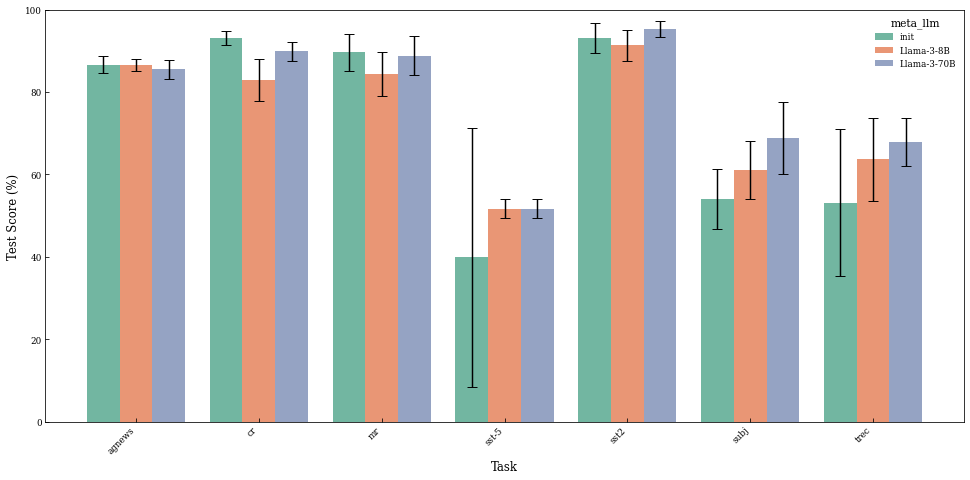

In [463]:
df_plot = best_scores_all[best_scores_all['optimizer'] == 'GA'].copy()
init_prompts = best_scores_all[best_scores_all["optimizer"]=="init"]

df_plot = pd.concat([df_plot, init_prompts])
plot_bar(df_plot, "meta_llm")


In [464]:
df_plot = best_scores_all[best_scores_all['optimizer'] == 'DE'].copy()
init_prompts = best_scores_all[(best_scores_all["optimizer"]=="init")]

df_plot = pd.concat([df_plot, init_prompts])


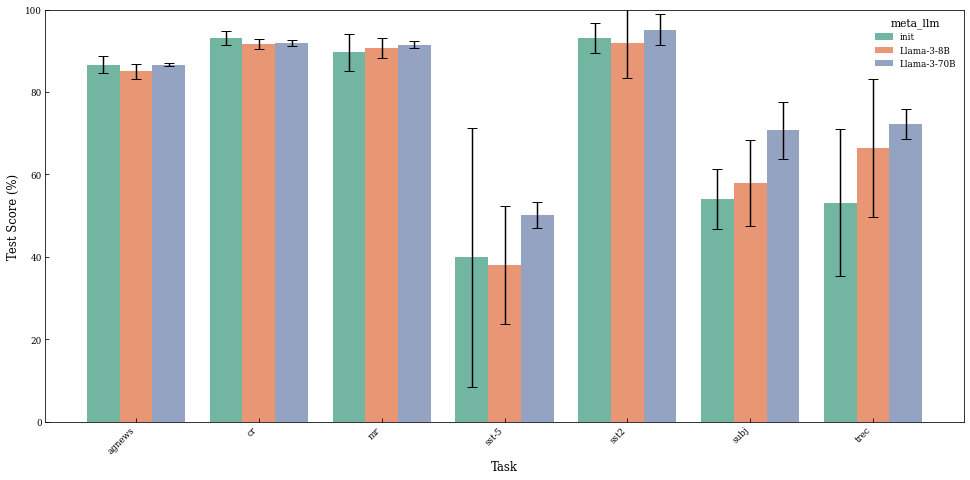

In [465]:
plot_bar(df_plot, "meta_llm")


In [466]:
fancy_pants = format_score(best_scores_all)
get_result_table(fancy_pants)

task                                               Average        agnews  \
meta_llm    downstream_llm optimizer use_task_desc                         
Llama-3-70B Llama-3-70B    DE        False           79.74  86.67 ± 0.29   
                           GA        False           78.26  85.50 ± 2.29   
Llama-3-8B  Llama-3-70B    DE        False           74.52  85.00 ± 1.80   
                           GA        False           74.50  86.50 ± 1.50   
init        Llama-3-70B    init      False           72.81  86.67 ± 2.02   

task                                                          cr  \
meta_llm    downstream_llm optimizer use_task_desc                 
Llama-3-70B Llama-3-70B    DE        False          91.83 ± 0.76   
                           GA        False          89.83 ± 2.25   
Llama-3-8B  Llama-3-70B    DE        False          91.67 ± 1.15   
                           GA        False          83.00 ± 5.07   
init        Llama-3-70B    init      False          93.17 ± 1.76   

task                                                          mr  \
meta_llm    downstream_llm optimizer use_task_desc                 
Llama-3-70B Llama-3-70B    DE        False          91.50 ± 0.87   
                           GA        False          88.83 ± 4.65   
Llama-3-8B  Llama-3-70B    DE        False          90.67 ± 2.36   
                           GA        False          84.33 ± 5.30   
init        Llama-3-70B    init      False          89.67 ± 4.48   

task                                                        sst-5  \
meta_llm    downstream_llm optimizer use_task_desc                  
Llama-3-70B Llama-3-70B    DE        False           50.17 ± 3.25   
                           GA        False           51.67 ± 2.25   
Llama-3-8B  Llama-3-70B    DE        False          38.00 ± 14.31   
                           GA        False           51.67 ± 2.36   
init        Llama-3-70B    init      False          39.83 ± 31.32   

task                                                        sst2  \
meta_llm    downstream_llm optimizer use_task_desc                 
Llama-3-70B Llama-3-70B    DE        False          95.17 ± 3.69   
                           GA        False          95.33 ± 2.02   
Llama-3-8B  Llama-3-70B    DE        False          92.00 ± 8.67   
                           GA        False          91.33 ± 3.79   
init        Llama-3-70B    init      False          93.17 ± 3.69   

task                                                         subj  \
meta_llm    downstream_llm optimizer use_task_desc                  
Llama-3-70B Llama-3-70B    DE        False           70.67 ± 6.83   
                           GA        False           68.83 ± 8.75   
Llama-3-8B  Llama-3-70B    DE        False          58.00 ± 10.44   
                           GA        False           61.00 ± 7.00   
init        Llama-3-70B    init      False           54.00 ± 7.26   

task                                                         trec  
meta_llm    downstream_llm optimizer use_task_desc                 
Llama-3-70B Llama-3-70B    DE        False           72.17 ± 3.69  
                           GA        False           67.83 ± 5.77  
Llama-3-8B  Llama-3-70B    DE        False          66.33 ± 16.74  
                           GA        False          63.67 ± 10.05  
init        Llama-3-70B    init      False          53.17 ± 17.86

## Results
- we can get worse than initial prompts in certain tasks
- variance of small model almost always higher

# Task Description

In [467]:
df_comparison = read_best_scores("experiment")
df_comparison = clean_names(df_comparison)
df_comparison = df_comparison[df_comparison.meta_llm == "Llama-3-8B"]
df_comparison = get_mean_std(df_comparison)
df_comparison = get_avg_across_tasks(df_comparison)

In [468]:
best_scores_td = read_best_scores("experiment-task-descr")
best_scores_td = get_mean_std(best_scores_td)
best_scores_td = get_avg_across_tasks(best_scores_td)
best_scores_td = clean_names(best_scores_td)

In [469]:
df_plot = pd.concat([best_scores_td, df_comparison])
fancy_pants = format_score(df_plot)
get_result_table(fancy_pants)

task                                              Average        agnews  \
meta_llm   downstream_llm optimizer use_task_desc                         
Llama-3-8B Llama-3-70B    DE        False           74.52  85.00 ± 1.80   
                                    True            78.12  87.33 ± 0.76   
                          GA        False           74.50  86.50 ± 1.50   
                                    True            76.50  85.67 ± 1.04   

task                                                         cr            mr  \
meta_llm   downstream_llm optimizer use_task_desc                               
Llama-3-8B Llama-3-70B    DE        False          91.67 ± 1.15  90.67 ± 2.36   
                                    True           93.00 ± 0.00  87.33 ± 1.04   
                          GA        False          83.00 ± 5.07  84.33 ± 5.30   
                                    True           89.83 ± 3.18  91.17 ± 3.01   

task                                                       sst-5  \
meta_llm   downstream_llm optimizer use_task_desc                  
Llama-3-8B Llama-3-70B    DE        False          38.00 ± 14.31   
                                    True            51.33 ± 3.40   
                          GA        False           51.67 ± 2.36   
                                    True            46.67 ± 2.25   

task                                                       sst2  \
meta_llm   downstream_llm optimizer use_task_desc                 
Llama-3-8B Llama-3-70B    DE        False          92.00 ± 8.67   
                                    True           94.17 ± 4.65   
                          GA        False          91.33 ± 3.79   
                                    True           91.50 ± 8.26   

task                                                        subj  \
meta_llm   downstream_llm optimizer use_task_desc                  
Llama-3-8B Llama-3-70B    DE        False          58.00 ± 10.44   
                                    True            59.17 ± 9.25   
                          GA        False           61.00 ± 7.00   
                                    True            66.33 ± 6.25   

task                                                        trec  
meta_llm   downstream_llm optimizer use_task_desc                 
Llama-3-8B Llama-3-70B    DE        False          66.33 ± 16.74  
                                    True            74.50 ± 5.41  
                          GA        False          63.67 ± 10.05  
                                    True            64.33 ± 2.25

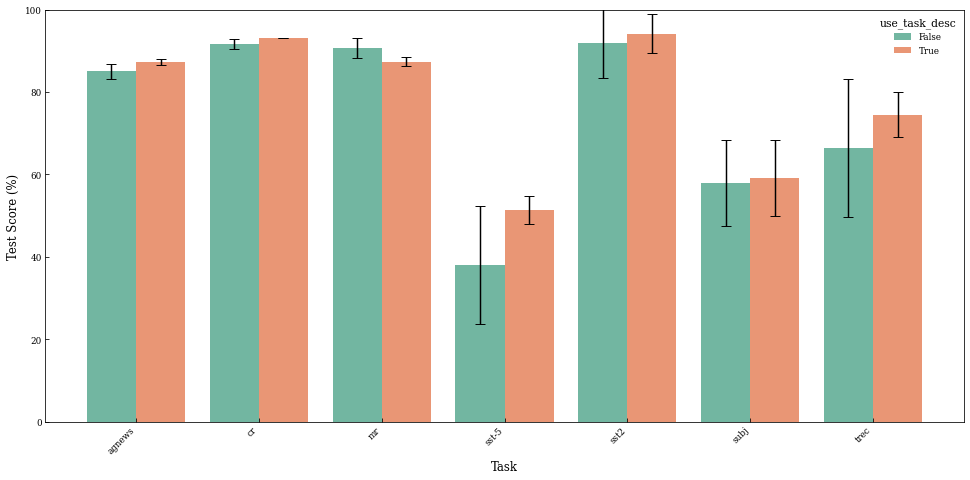

In [470]:
df_plot = pd.concat([best_scores_td, df_comparison])
df_plot = df_plot[df_plot.optimizer == "DE"]
plot_bar(df_plot, "use_task_desc")

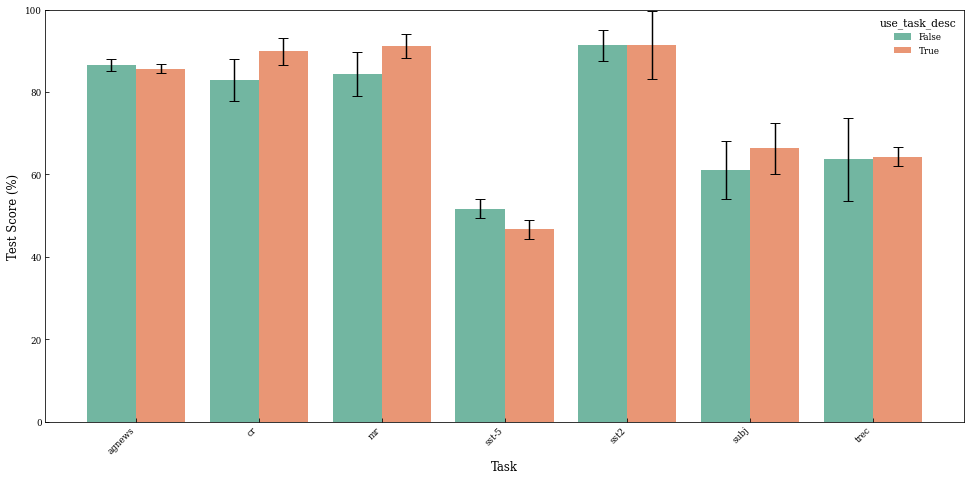

In [472]:
df_plot = pd.concat([best_scores_td, df_comparison])
df_plot = df_plot[df_plot.optimizer == "GA"]
plot_bar(df_plot, "use_task_desc")

# Different model families

In [473]:
df_experiment = read_best_scores("experiment_gpt")
df_experiment = df_experiment.drop("train_score", axis="columns")
df_experiment["use_task_desc"] = False
df_experiment = clean_names(df_experiment)
df_experiment = get_mean_std(df_experiment)
df_experiment = get_avg_across_tasks(df_experiment)

In [474]:
df_comparison = read_best_scores("experiment")
df_comparison = clean_names(df_comparison)
df_comparison = df_comparison[df_comparison["meta_llm"]=="Llama-3-70B"]
df_comparison = df_comparison[df_comparison["use_task_desc"]==False]
df_comparison = df_comparison[df_comparison["optimizer"]=="DE"]
df_comparison = df_comparison[df_comparison["task"].isin(df_experiment.task.unique())]

df_comparison = get_mean_std(df_comparison)
df_comparison = get_avg_across_tasks(df_comparison)

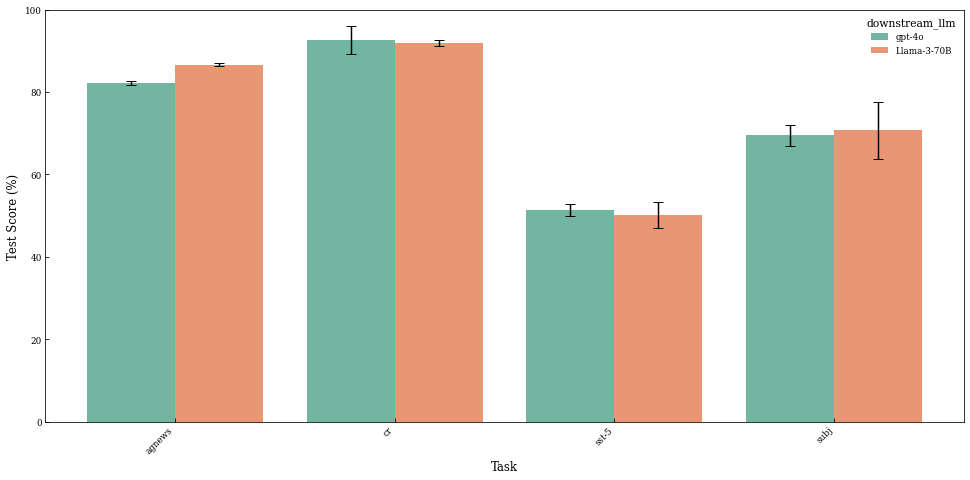

In [475]:
df_plot = pd.concat([df_experiment, df_comparison])
plot_bar(df_plot, hue="downstream_llm")

In [476]:
fancy_pants = format_score(df_plot)
get_result_table(fancy_pants)

task                                               Average        agnews  \
meta_llm    downstream_llm optimizer use_task_desc                         
Llama-3-70B Llama-3-70B    DE        False           74.83  86.67 ± 0.29   
            gpt-4o         DE        False           73.92  82.17 ± 0.58   

task                                                          cr  \
meta_llm    downstream_llm optimizer use_task_desc                 
Llama-3-70B Llama-3-70B    DE        False          91.83 ± 0.76   
            gpt-4o         DE        False          92.67 ± 3.33   

task                                                       sst-5          subj  
meta_llm    downstream_llm optimizer use_task_desc                              
Llama-3-70B Llama-3-70B    DE        False          50.17 ± 3.25  70.67 ± 6.83  
            gpt-4o         DE        False          51.33 ± 1.53  69.50 ± 2.60

# DE vs GA (70 B only)

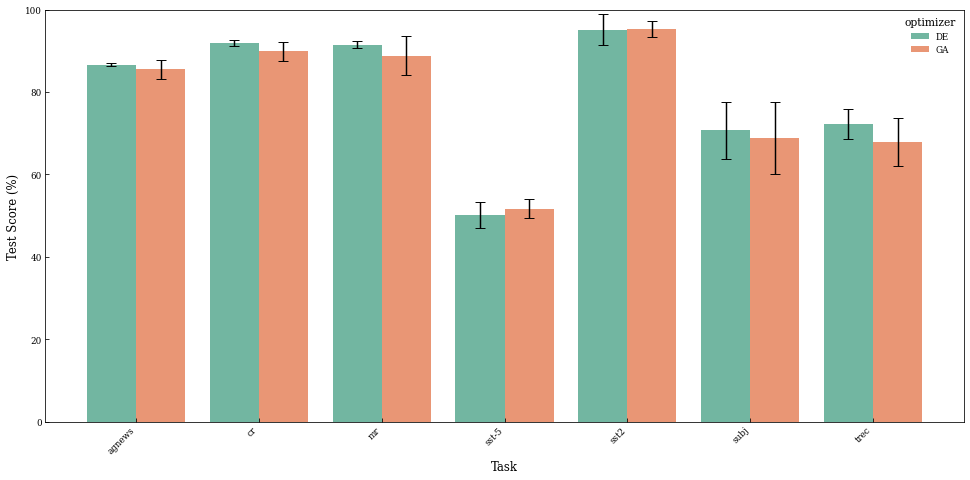

In [477]:
df_comparison = read_best_scores("experiment")
df_comparison = clean_names(df_comparison)
df_comparison = df_comparison[df_comparison["meta_llm"]=="Llama-3-70B"]

df_comparison = get_mean_std(df_comparison)
df_comparison = get_avg_across_tasks(df_comparison)

plot_bar(df_comparison, hue="optimizer")

In [478]:
fancy_pants = format_score(df_comparison)
get_result_table(fancy_pants)

task                                               Average        agnews  \
meta_llm    downstream_llm optimizer use_task_desc                         
Llama-3-70B Llama-3-70B    DE        False           79.74  86.67 ± 0.29   
                           GA        False           78.26  85.50 ± 2.29   

task                                                          cr  \
meta_llm    downstream_llm optimizer use_task_desc                 
Llama-3-70B Llama-3-70B    DE        False          91.83 ± 0.76   
                           GA        False          89.83 ± 2.25   

task                                                          mr  \
meta_llm    downstream_llm optimizer use_task_desc                 
Llama-3-70B Llama-3-70B    DE        False          91.50 ± 0.87   
                           GA        False          88.83 ± 4.65   

task                                                       sst-5  \
meta_llm    downstream_llm optimizer use_task_desc                 
Llama-3-70B Llama-3-70B    DE        False          50.17 ± 3.25   
                           GA        False          51.67 ± 2.25   

task                                                        sst2  \
meta_llm    downstream_llm optimizer use_task_desc                 
Llama-3-70B Llama-3-70B    DE        False          95.17 ± 3.69   
                           GA        False          95.33 ± 2.02   

task                                                        subj          trec  
meta_llm    downstream_llm optimizer use_task_desc                              
Llama-3-70B Llama-3-70B    DE        False          70.67 ± 6.83  72.17 ± 3.69  
                           GA        False          68.83 ± 8.75  67.83 ± 5.77

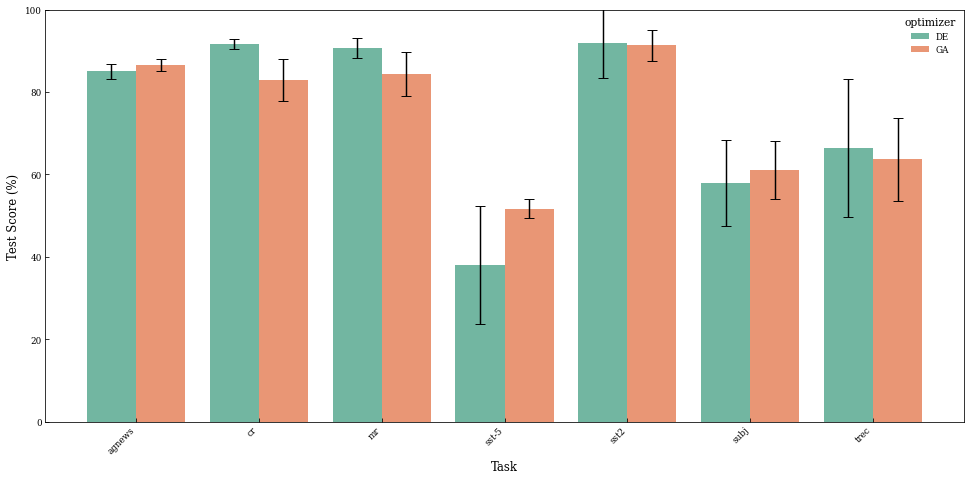

In [479]:
df_comparison = read_best_scores("experiment")
df_comparison = clean_names(df_comparison)
df_comparison = df_comparison[df_comparison["meta_llm"]=="Llama-3-8B"]

df_comparison = get_mean_std(df_comparison)
df_comparison = get_avg_across_tasks(df_comparison)

plot_bar(df_comparison, hue="optimizer")

In [480]:
fancy_pants = format_score(df_comparison)
get_result_table(fancy_pants)

task                                              Average        agnews  \
meta_llm   downstream_llm optimizer use_task_desc                         
Llama-3-8B Llama-3-70B    DE        False           74.52  85.00 ± 1.80   
                          GA        False           74.50  86.50 ± 1.50   

task                                                         cr            mr  \
meta_llm   downstream_llm optimizer use_task_desc                               
Llama-3-8B Llama-3-70B    DE        False          91.67 ± 1.15  90.67 ± 2.36   
                          GA        False          83.00 ± 5.07  84.33 ± 5.30   

task                                                       sst-5  \
meta_llm   downstream_llm optimizer use_task_desc                  
Llama-3-8B Llama-3-70B    DE        False          38.00 ± 14.31   
                          GA        False           51.67 ± 2.36   

task                                                       sst2  \
meta_llm   downstream_llm optimizer use_task_desc                 
Llama-3-8B Llama-3-70B    DE        False          92.00 ± 8.67   
                          GA        False          91.33 ± 3.79   

task                                                        subj  \
meta_llm   downstream_llm optimizer use_task_desc                  
Llama-3-8B Llama-3-70B    DE        False          58.00 ± 10.44   
                          GA        False           61.00 ± 7.00   

task                                                        trec  
meta_llm   downstream_llm optimizer use_task_desc                 
Llama-3-8B Llama-3-70B    DE        False          66.33 ± 16.74  
                          GA        False          63.67 ± 10.05

# GPT 4o vs initial prompts

In [481]:
df_comparison = read_best_scores("experiment-initial-prompts")
df_comparison[["meta_llm", "optimizer", "use_task_desc", "evaluation_llm"]] = "init"
df_comparison=df_comparison.drop("prompt", axis="columns")
df_comparison = clean_names(df_comparison)
df_comparison = df_comparison[df_comparison["downstream_llm"]=="gpt-4o"]
df_comparison = df_comparison[df_comparison["task"].isin(df_experiment.task.unique())]
df_comparison = get_mean_std(df_comparison)
df_comparison = get_avg_across_tasks(df_comparison)

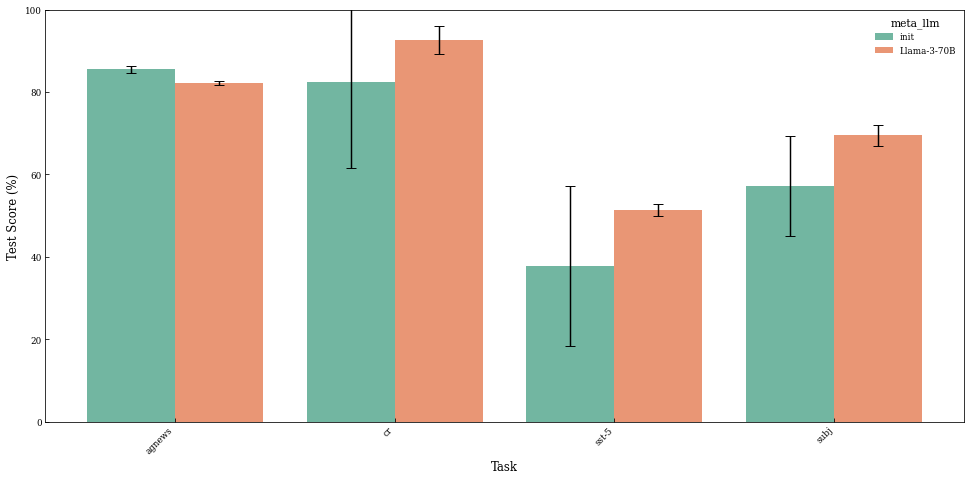

In [482]:
df_plot = pd.concat([df_experiment, df_comparison])
plot_bar(df_plot, hue="meta_llm")

In [483]:
fancy_pants = format_score(df_plot)
get_result_table(fancy_pants)

,,,task,Average,agnews,cr,sst-5,subj
meta_llm,downstream_llm,optimizer,use_task_desc,,,,,
Llama-3-70B,gpt-4o,DE,False,73.92,82.17 ± 0.58,92.67 ± 3.33,51.33 ± 1.53,69.50 ± 2.60
init,gpt-4o,init,False,65.71,85.50 ± 0.87,82.33 ± 20.71,37.83 ± 19.43,57.17 ± 12.10


# Results
- gpt-4o seems to be more sensitive to prompt than llama